In [2]:
from scipy.io import wavfile
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from scipy.fft import rfft, rfftfreq
from scipy.signal import decimate, butter, lfilter, correlate, find_peaks
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [3]:
def parabolic(f, x):
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    start = np.nonzero(d > 0)[0][0]
    peak = np.argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

In [4]:
def integrate_area(x, y, a, b):
    # Create linear interpolation function for the curve
    f = interp1d(x, y, kind='linear')
    ic(f)
    
    # Perform numerical integration between a and b
    area, _ = quad(f, a, b)
    return area

In [5]:
# Reference https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

ic| data: array([ -8,   6, -11, ...,   0,  -1,   2], shape=(10000,), dtype=int16)
ic| np.mean(data): np.float64(-0.396)
ic| data: array([ -7.604,   6.396, -10.604, ...,   0.396,  -0.604,   2.396],
                shape=(10000,))
ic| np.mean(data): np.float64(4.320099833421409e-16)


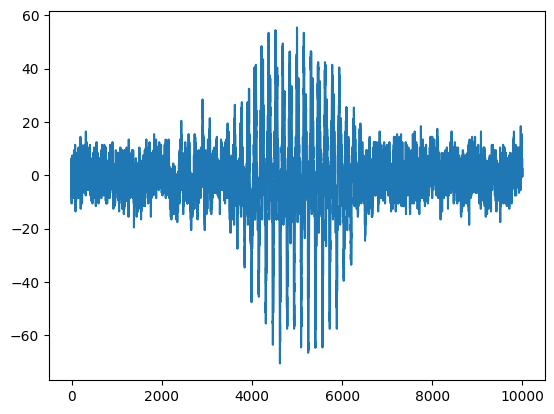

In [6]:
waveform_path = '/home/aubrey/Desktop/wingbeat-recorder/example_waveforms/2025-04-19T14:46:23.649496+08:00.wav'
sr, data = wavfile.read(waveform_path)
ic(data)
ic(np.mean(data))
data = data - np.mean(data)  # Remove DC offset; note that data.dtype converts from int(16) to float(32)
ic(data)
ic(np.mean(data))
plt.plot(data);

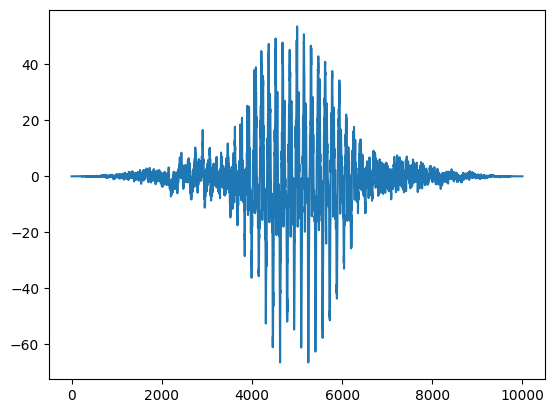

In [7]:
sr, data = wavfile.read(waveform_path)

#apply bandpass filter
data = butter_bandpass_filter(data, lowcut=20, highcut=10000, fs=sr, order=5)

# remove DC offset
data = data - np.mean(data)  # Remove DC offset; note that data.dtype converts from int(16) to float(32)

# apply Hanning window
data = np.hanning(data.shape[0]) * data

plt.plot(data)

In [8]:

# Perform FFT and calculate frequency array
power = np.abs(rfft(data))
freq = rfftfreq(data.shape[0], 1/sr)
ic(freq)

# Normalize so that the area under the curve is 1
power = power / integrate_area(freq, power, freq[0], freq[-1])
ic(np.sum(power))
ic(integrate_area(freq, power, freq[0], freq[-1]))

ic| freq: array([0.00000e+00, 4.80000e+00, 9.60000e+00, ..., 2.39904e+04,
                 2.39952e+04, 2.40000e+04], shape=(5001,))
ic| f: <scipy.interpolate._interpolate.interp1d object at 0x7f86f7779530>
/tmp/ipykernel_506667/828253648.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area, _ = quad(f, a, b)
ic| np.sum(power): np.float64(0.20677807499561335)
ic| f: <scipy.interpolate._interpolate.interp1d object at 0x7f86f77a6ed0>
ic| integrate_area(freq, power, freq[0], freq[-1]): 0.9999999999999998


0.9999999999999998

In [9]:
ic(power)
ic(freq);


ic| power: array([3.72534382e-05, 2.35468514e-05, 1.94471516e-05, ...,
                  4.42209939e-15, 4.42205544e-15, 4.42206014e-15], shape=(5001,))
ic| freq: array([0.00000e+00, 4.80000e+00, 9.60000e+00, ..., 2.39904e+04,
                 2.39952e+04, 2.40000e+04], shape=(5001,))


In [10]:
from matplotlib.patches import Rectangle

mywidth = 40
shoulder = 4

wingbeat_frequency = freq_from_autocorr(data, fs=sr)
wingbeat_index = np.argmin(np.abs(freq - wingbeat_frequency))

power[wingbeat_index-shoulder:wingbeat_index+shoulder]

for i in range(3):
    print(i)


0
1
2


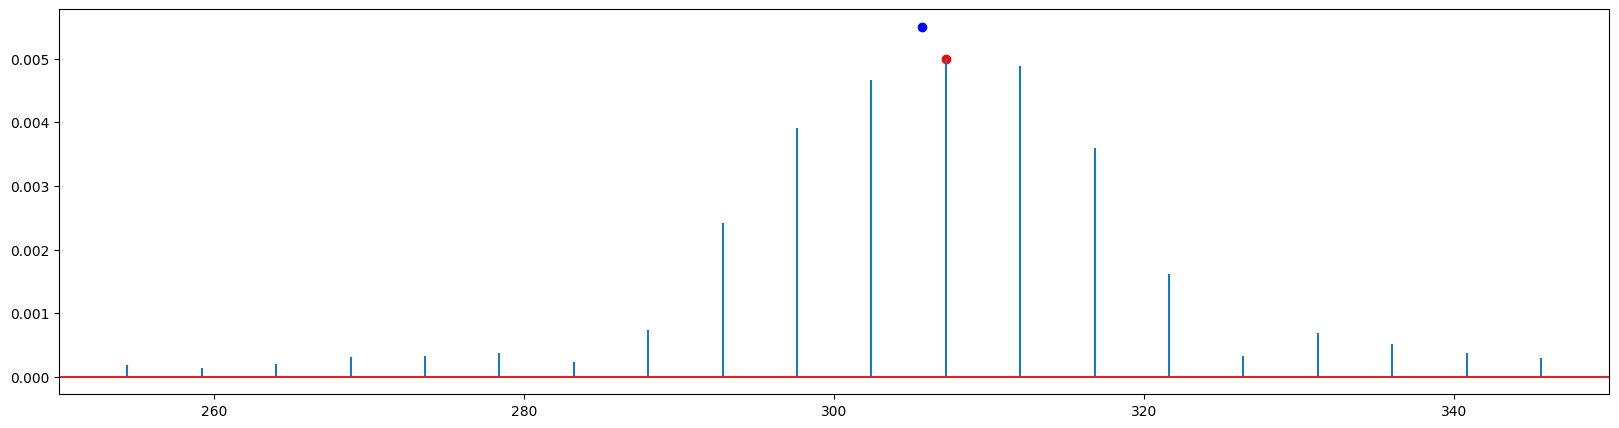

In [11]:
# Plot the FFT result
fig = plt.figure(figsize=(20, 5))
# plt.plot(freq, power)

plt.stem(freq, power, markerfmt=' ')
plt.xlim(250, 350)

# get index of wingbeat frequency
wingbeat_index = np.argmin(np.abs(freq - wingbeat_frequency))
plt.scatter(x=freq[wingbeat_index], y=power[wingbeat_index], color='red', label='Wingbeat Frequency')
plt.scatter(x=wingbeat_frequency, y=0.0055, color='blue')



# for i in range(20):
#     harmonic = wingbeat_frequency * (i + 1)
    
#     #Fill area under the curve
#     plt.fill_between(
#             x= freq, 
#             y1= power, 
#             where= (harmonic-mywidth/2 <= freq) & (freq <= harmonic+mywidth/2),
#             color= "red",
#             )
    
    

ic| result: {'peak_freq_array': array([288. , 292.8, 297.6, 302.4, 307.2, 312. , 316.8, 321.6, 326.4]),
             'peak_power_array': array([0.00072959, 0.00240976, 0.00390799, 0.00465879, 0.00499033,
                   0.00487753, 0.0035934 , 0.00161185, 0.00032652]),
             'sum_peak_power': np.float64(0.027105763872934466)}
ic| result: {'peak_freq_array': array([590.4, 595.2, 600. , 604.8, 609.6, 614.4, 619.2, 624. , 628.8]),
             'peak_power_array': array([7.90931413e-05, 9.70840969e-04, 1.97497216e-03, 2.77551818e-03,
                   3.01369723e-03, 2.62372231e-03, 2.20480495e-03, 1.62897015e-03,
                   7.65380019e-04]),
             'sum_peak_power': np.float64(0.01603699910090087)}
ic| result: {'peak_freq_array': array([897.6, 902.4, 907.2, 912. , 916.8, 921.6, 926.4, 931.2, 936. ]),
             'peak_power_array': array([1.44411143e-05, 2.89105032e-04, 4.61758190e-04, 6.00653616e-04,
                   7.32649374e-04, 8.77926908e-04, 8.01696715e

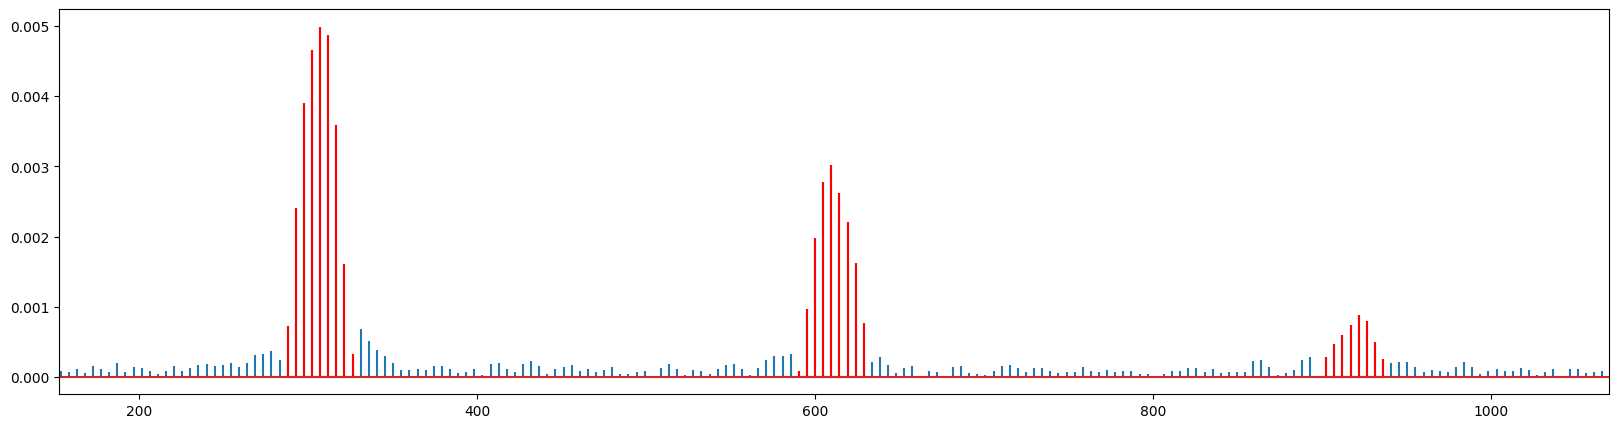

In [81]:
def measure_harmonic(freq_array, power_array, wingbeat_frequency, harmonic, shoulder):
    """ 
    asas
    """
    peak_index = np.argmin(np.abs(freq_array - (wingbeat_frequency * harmonic)))
    peak_roi = np.arange(peak_index-shoulder, peak_index+shoulder+1)
    peak_freq_array = freq_array[peak_roi]
    peak_power_array = power_array[peak_roi]
    return {'peak_freq_array': peak_freq_array, 'peak_power_array': peak_power_array, 'sum_peak_power': np.sum(peak_power_array)}

fig = plt.figure(figsize=(20, 5))
plt.stem(freq, power, markerfmt=' ')
plt.xlim(0.5*wingbeat_frequency, 3.5*wingbeat_frequency)

for harmonic in [1,2,3]:
    result = measure_harmonic(freq, power, wingbeat_frequency, harmonic, shoulder=4)
    ic(result)
    plt.stem(result['peak_freq_array'], result['peak_power_array'], markerfmt=' ', linefmt='red')

In [38]:
# Define categories
categories = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

# Create a structured numpy array with x, y, and category
structured_array = np.array(list(zip(x, y, categories)), dtype=[('x', 'f8'), ('y', 'f8'), ('category', 'U1')])

ic(structured_array);

ic| structured_array: array([(2121.6, 3.82650433e-05, 'A'), (2126.4, 6.17807715e-05, 'B'),
                             (2131.2, 9.69923367e-05, 'C'), (2136. , 2.32069885e-05, 'D'),
                             (2140.8, 7.14128239e-05, 'E'), (2145.6, 6.48684382e-05, 'F'),
                             (2150.4, 2.77968958e-05, 'G'), (2155.2, 7.54491770e-05, 'H'),
                             (2160. , 1.27121826e-04, 'I')],
                            dtype=[('x', '<f8'), ('y', '<f8'), ('category', '<U1')])


In [12]:
# Peak integration 

# reference: https://youtu.be/eGnSmBb1nqw?si=5ezEcHBRw9y_XcL0

maxfreq = 5000
peakwidth = 40

# filter arrays so that they only include frequencies <= 5000 Hz

ic(freq);
newfreq = freq[freq <= maxfreq]
ic(newfreq);

ic(power);
newpower = power[:len(newfreq)]
ic(newpower);

# Normalize so that the area under the curve is 1
area = integrate_area(newfreq, newpower, newfreq[0], newfreq[-1])
ic(area)
newpower = newpower / area
area = integrate_area(newfreq, newpower, newfreq[0], newfreq[-1])
ic(area)

harmonics = np.arange(start=wingbeat_frequency, step=wingbeat_frequency, stop=5000-peakwidth)
ic(harmonics)

# integrate area under the curve for each harmonic
peakareas = [integrate_area(newfreq, newpower, hz-peakwidth/2, hz+peakwidth/2) for hz in harmonics]
ic(peakareas)
ic(sum(peakareas));   
    

ic| freq: array([0.00000e+00, 4.80000e+00, 9.60000e+00, ..., 2.39904e+04,
                 2.39952e+04, 2.40000e+04], shape=(5001,))
ic| newfreq: array([0.0000e+00, 4.8000e+00, 9.6000e+00, ..., 4.9872e+03, 4.9920e+03,
                    4.9968e+03], shape=(1042,))
ic| power: array([3.72534382e-05, 2.35468514e-05, 1.94471516e-05, ...,
                  4.42209939e-15, 4.42205544e-15, 4.42206014e-15], shape=(5001,))
ic| newpower: array([3.72534382e-05, 2.35468514e-05, 1.94471516e-05, ...,
                     5.45018163e-05, 1.60428865e-05, 5.97593129e-05], shape=(1042,))
ic| f: <scipy.interpolate._interpolate.interp1d object at 0x7f86f993b330>
/tmp/ipykernel_506667/828253648.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  

ic| harmonic: np.float64(2139.6668441617294)
ic| idx: np.int64(446)
ic| x: array([2121.6, 2126.4, 2131.2, 2136. , 2140.8, 2145.6, 2150.4, 2155.2,
              2160. ])
ic| y: array([3.82650433e-05, 6.17807715e-05, 9.69923367e-05, 2.32069885e-05,
              7.14128239e-05, 6.48684382e-05, 2.77968958e-05, 7.54491770e-05,
              1.27121826e-04])
ic| area: np.float64(0.0024201641570531706)
ic| myrange: np.float64(38.40000000000009)


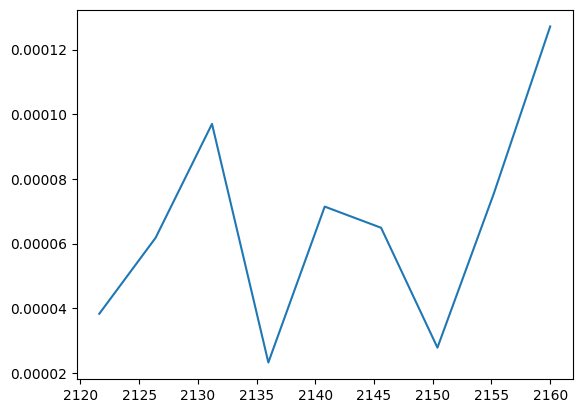

In [21]:
shoulder = 4



ic(wingbeat_frequency)


np.float64(305.6666920231042)

[Stop struggling with peaks](https://youtu.be/wAmlfQqhCh0?si=Jqo7KEBkGiE5-odx)

[Matering peak integration visualization](https://youtu.be/eGnSmBb1nqw?si=BCGdecLas2Tn6YmQ)

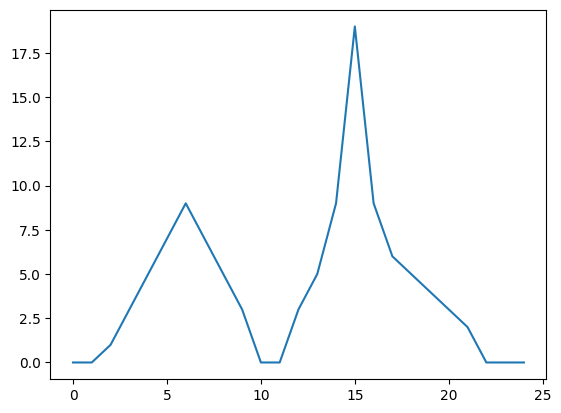

In [14]:
peak = np.array([0,0,1,3,5,7,9,7,5,3,0,0,3,5,9,19,9,6,5,4,3,2,0,0,0])
plt.plot(peak)
plt.show()

In [15]:
# quad(peak, 1, 10)

In [16]:
peaks, info = find_peaks(peak, width=1)
ic(peaks)
ic(info);

ic| 

peaks: array([ 6, 15])
ic| info: {'left_bases': array([ 1, 11]),
           'left_ips': array([ 3.75, 14.05]),
           'prominences': array([ 9., 19.]),
           'right_bases': array([10, 22]),
           'right_ips': array([ 8.25, 15.95]),
           'width_heights': array([4.5, 9.5]),
           'widths': array([4.5, 1.9])}


In [17]:
np.trapezoid(peak[1:10])

np.float64(38.5)

# Downsample factor 8

In [18]:
# ic(waveform_path)
# sr, data = wavfile.read(waveform_path)
# ic(type(sr))
# ic(sr);
# ic(data)

# downsample_factor = 8
# data = data[::downsample_factor]
# sr = sr // downsample_factor
# ic(type(sr))
# ic(sr)
# ic(data)

# plt.plot(data)

# wavfile.write('downsampled.wav', sr, data)

In [19]:
# sr, data = wavfile.read(waveform_path)

# #apply bandpass filter
# data = butter_bandpass_filter(data, lowcut=20, highcut=10000, fs=sr, order=5)

# # remove DC offset
# data = data - np.mean(data)  # Remove DC offset; note that data.dtype converts from int(16) to float(32)

# # apply Hanning window
# data = np.hanning(data.shape[0]) * data

# plt.plot(data)

In [20]:
# # Perform FFT and calculate frequency array
# power = np.abs(rfft(data))
# freq = rfftfreq(data.shape[0], 1/sr)
# ic(freq)

# # Plot the FFT result
# plt.stem(freq, power, markerfmt=' ')
# plt.xlim(0, 5000)